In [52]:
!pip install tables
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pickle import dump, load
from sklearn.utils import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from collections import OrderedDict

combined_data = pd.read_hdf("source_files/combined_data_C3.hdf5")

INPUT_COLUMNS = ["start_speed", "spin_rate", "spin_dir", "px", "pz", "pitch_type"]
CONTEXT_COLUMNS = ["b_score", "p_score", "b_count", "s_count", "outs", "pitch_num", \
    "on_1b", "on_2b", "on_3b", "inning", "p_throws", "stand", "top"]
OUTPUT_COLUMNS = ["event"]

inputs = combined_data[INPUT_COLUMNS].copy()
context = combined_data[CONTEXT_COLUMNS].copy()

#------------- One-Hot Encode  -----------------
inputs = pd.concat([inputs, pd.get_dummies(inputs.pitch_type)], axis=1)
inputs = inputs.drop(labels="pitch_type", axis=1)

context[["p_throws", "stand"]] = context[["p_throws", "stand"]] == "R"
context[["p_throws", "stand", "top"]] = context[["p_throws", "stand", "top"]].astype(int)
context = context.rename(columns={"p_throws":"p_isrighty", "stand":"b_isrighty", "top":"is_top_inning"})

combined_inputs = pd.concat([inputs, context], axis=1)
# print(combined_inputs.columns)
#Normalization
scaler = StandardScaler().fit(combined_inputs)
combined_inputs = scaler.transform(combined_inputs)
dump(scaler, open('scaler.pkl', 'wb'))

# nn_data = pd.concat([combined_inputs, combined_data[OUTPUT_COLUMNS]], axis=1)
# nn_data.to_hdf("../source_files/model_data.hdf5", key="df")

raw_outputs = pd.get_dummies(combined_data["pitch_event"], dtype="float")
event_names = raw_outputs.columns
# print(raw_outputs)

rename_dict = {
    "*B": "Ball in Dirt",
    "B": "Ball",
    "C": "Called Strike",
    "F": "Foul Ball",
    "H": "Hit by pitch",
    "L": "Foul Bunt",
    "W": "Swinging Strike (Blocked)",
    "M": "Missed Bunt",
    "S": "Swinging Strike",
    "T": "Foul Tip",
}

#print(pd.DataFrame(event_names.values))
event_names = pd.DataFrame(event_names.values).replace(to_replace=rename_dict)
# print(event_names)

combined_inputs = torch.tensor(combined_inputs, dtype=torch.float32).cuda()
outputs = torch.tensor(raw_outputs.values, dtype=torch.float32).cuda()



In [30]:
class FFNetPytorch(nn.Module):
  sm = torch.nn.Softmax(dim = 1)
  def __init__(self, input_size, output_size, hl1=100, hl2=25):
    super(FFNetPytorch, self).__init__()
    '''
    Define the layers of the neural network. One hidden layer and output layer.
    The activation function used in between the two layers is sigmoid.
    '''
    self.layer1 = nn.Linear(input_size, hl1, bias = True)
    self.layer2 = nn.Linear(hl1, output_size, bias = True)
    # self.layer3 = nn.Linear(hl2, output_size, bias = True)

    self.to(torch.float32)
    

  def forward(self, x):
    '''
    :param x: input to the model (N, NUM_FEATURES)

    :return:
      output: logits of the last layer of the model 
    '''
    x = torch.relu(self.layer1(x))
    # x = torch.relu(self.layer2(x))
    x = self.sm(self.layer2(x))

    return x

class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, i):
    return self.X[i, ...], self.Y[i]
  
  def __len__(self):
    return self.X.shape[0]


Training

In [8]:
# from pyinstrument import Profiler

# profiler = Profiler()
# profiler.start()

#------------- Train --------------
X_train, X_test, Y_train, Y_test = \
    train_test_split(combined_inputs, outputs, test_size=0.2, random_state=42)

NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = outputs.shape[1]

HIDDEN1_SIZE = 512
HIDDEN2_SIZE = 128

batch_size = 512
max_epochs = 100

print_every = 1
test_every = 1
SAVE_EVERY = 10

LR = 1e-3

SAVE_MODEL = True
LOAD_MODEL = False
SAVE_PATH = "HL1_" + str(HIDDEN1_SIZE)
MODEL_SAVE_PATH = "scripts/event/models/" + SAVE_PATH + ".pt"
TRAIN_LOSSES_SAVE_PATH = "scripts/event/trainingloss/" + SAVE_PATH + ".csv"
TEST_LOSSES_SAVE_PATH = "scripts/event/testloss/" + SAVE_PATH + ".csv"
ACCURACY_SAVE_PATH = "scripts/event/accuracies/" + SAVE_PATH + ".csv"

CONV_SIZE = 10 #CONVERGENCE_WINDOW_SIZE
CONVERGENCE_THRESHOLD = 0.0003

model = FFNetPytorch(NUM_FEATURES, NUM_CLASSES, hl1=HIDDEN1_SIZE, hl2=HIDDEN2_SIZE)
train_losses =[]
test_losses=[]
train_accuracies = []

if LOAD_MODEL:
    try:
      model = torch.load(MODEL_SAVE_PATH)
      train_losses = np.fromfile(TRAIN_LOSSES_SAVE_PATH, sep=',').tolist()
      test_losses = np.fromfile(TEST_LOSSES_SAVE_PATH, sep=',').tolist()
      train_accuracies = np.fromfile(ACCURACY_SAVE_PATH, sep=',').tolist()
    except FileNotFoundError:
      pass
  
# weight = compute_class_weight(class_weight = "balanced", classes= np.unique(combined_data["pitch_event"]), y = combined_data["pitch_event"])
# print(pd.Series(weight, index=np.unique(combined_data["pitch_event"])))

#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)#, weight_decay=1e-5)
#loss_fn = nn.CrossEntropyLoss(weight = torch.tensor(weight))
loss_fn = nn.MSELoss()
#torch.manual_seed(314139)
device = "cuda"



dataset_train = CustomDataset(X_train, Y_train)
dataset_test = CustomDataset(X_test, Y_test)

model = model.to(device)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

max_epoch = max_epochs + len(train_losses)
train_dif = 0
epoch = len(train_losses)

train_mbatches = X_train.shape[0] // batch_size
test_mbatches = X_test.shape[0] // batch_size

print(model)
model.train()
while epoch < max_epoch \
and (train_dif > CONVERGENCE_THRESHOLD or train_dif == 0):

  batch_losses = []
  batch_accuracies = []
  shuffle_array = torch.randperm(X_train.shape[0])
  X_train[shuffle_array, :]
  
  for batch_idx in range(train_mbatches):
    data = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
    target = Y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    prediction = output
    #print(torch.argmax(prediction, dim = 1),torch.argmax(target, dim = 1))
    #print(torch.argmax(target, dim = 1))
    accuracy = torch.sum(torch.argmax(prediction, dim = 1) == torch.argmax(target, dim = 1))/len(target)
    #print(accuracy)
    loss.backward()
    optimizer.step()
    #print(loss.item())
    batch_losses.append(loss.item())
    batch_accuracies.append(accuracy.item())
  
  test_accuracy = torch.mean(torch.Tensor(batch_accuracies)).item()
  train_accuracies.append(test_accuracy)
  train_losses.append(torch.mean(torch.Tensor(batch_losses)).item())
  train_dif = (np.max(train_losses[-CONV_SIZE:])-np.min(train_losses[-CONV_SIZE:]))/np.mean(train_losses[-CONV_SIZE:])
  
  model.eval()
  batch_losses = []

  if epoch % test_every == 0:
    for batch_idx in range(test_mbatches):
      data = X_test[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
      target = Y_test[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
      output = model(data)
      loss = loss_fn(output, target)
      batch_losses.append(loss.item())

    test_losses.append(torch.mean(torch.Tensor(batch_losses)).item())

  if SAVE_MODEL & (epoch % SAVE_EVERY == 0) & (epoch != 0):
    print("----- SAVED -----")
    torch.save(model, MODEL_SAVE_PATH)
    np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
    np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
    np.asarray(train_accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')

  if epoch % print_every == 0:
    print('{epoch}/{max_epoch}, Train Loss: {loss:.6f}, Test Loss: {test_loss:.6f}, Accuracy: {accuracy:.4f}%, Difference {diff:.3f}%'.format(
                epoch=epoch, max_epoch=max_epoch, loss=train_losses[-1], test_loss=test_losses[-1], \
                accuracy = test_accuracy*100, diff=train_dif*100))

  epoch += 1

if SAVE_MODEL:
  torch.save(model, MODEL_SAVE_PATH)
  np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
  np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
  np.asarray(train_accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')


FFNetPytorch(
  (layer1): Linear(in_features=28, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=27, bias=True)
)
0/100, Train Loss: 0.022912, Test Loss: 0.022409, Accuracy: 52.6338%, Difference 0.000%
1/100, Train Loss: 0.022324, Test Loss: 0.022227, Accuracy: 53.8306%, Difference 2.602%
2/100, Train Loss: 0.022200, Test Loss: 0.022151, Accuracy: 54.0306%, Difference 3.171%
3/100, Train Loss: 0.022134, Test Loss: 0.022113, Accuracy: 54.1459%, Difference 3.475%
4/100, Train Loss: 0.022098, Test Loss: 0.022095, Accuracy: 54.1962%, Difference 3.649%
5/100, Train Loss: 0.022071, Test Loss: 0.022082, Accuracy: 54.2489%, Difference 3.773%
6/100, Train Loss: 0.022051, Test Loss: 0.022070, Accuracy: 54.2733%, Difference 3.869%
7/100, Train Loss: 0.022036, Test Loss: 0.022064, Accuracy: 54.3061%, Difference 3.941%
8/100, Train Loss: 0.022024, Test Loss: 0.022057, Accuracy: 54.3245%, Difference 4.001%
9/100, Train Loss: 0.022013, Test Loss: 0.022054, Accuracy: 54.3

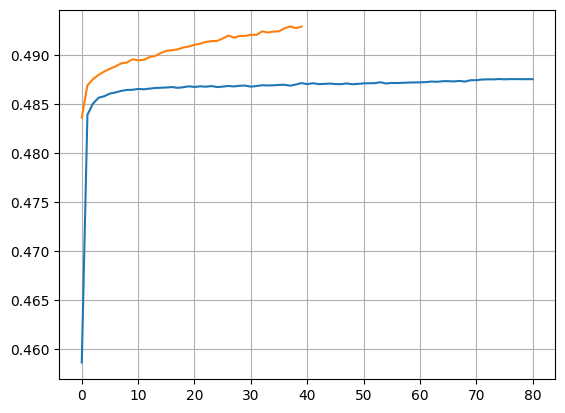

In [54]:
import matplotlib.pyplot as plt


acc_64_64 = np.fromfile("event/accuracies/HL2_256.csv", sep=',').tolist()
acc_256_256 = np.fromfile("event/accuracies/HL2_256_256.csv", sep=',').tolist()

plt.figure()
plt.plot(acc_64_64)
plt.plot(acc_256_256)
plt.grid()
#plt.ylim(3.08, 3.3)
plt.show()

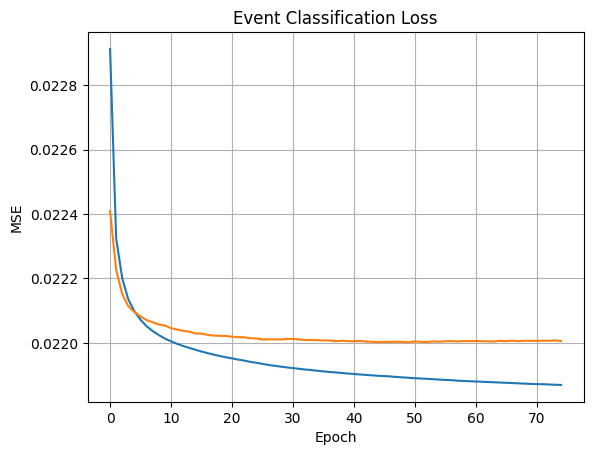

In [10]:
import matplotlib.pyplot as plt


acc_64_64 = np.fromfile("scripts/event/trainingloss/HL1_512.csv", sep=',').tolist()
test_64_64 = np.fromfile("scripts/event/testloss/HL1_512.csv", sep=',').tolist()


plt.figure()
plt.plot(acc_64_64)
plt.plot(test_64_64)

plt.grid()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Event Classification Loss")
#plt.ylim(3.08, 3.3)
plt.show()

In [15]:
context = {
    "b_score": 0,
    "p_score": 0,
    "b_count": 0,
    "s_count": 0,
    "outs": 0,
    "pitch_num": 1,
    "on_1b": 1,
    "on_2b": 1,
    "on_3b": 0,
    "inning": 1,
    "p_isrighty": 0,
    "b_isrighty": 0,
    "is_top_inning": 1
}
indexes = [key for key, val in context.items()]
values = [val for key, val in context.items()]
context = pd.Series(values, index=indexes, dtype=float)


inputs = {
    "start_speed": 90,
    "spin_rate": 1300,
    "spin_dir": 159,
    "px": 0,
    "pz": 2,
    "pitch_type": "FF"
}

PITCH_TYPES = ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 'KN', 'SI', 'SL']

pitches = [inputs["pitch_type"]==val for val in PITCH_TYPES]
pitches = pd.Series(pitches, index=PITCH_TYPES, dtype=float)

model = "/event/models/HL1_512.pt"
model = torch.load(MODEL_SAVE_PATH)
model.eval()
inputs = pd.Series([inputs["start_speed"], inputs["spin_rate"], inputs["spin_dir"], inputs["px"], inputs["pz"]], index=["start_speed", "spin_rate", "spin_dir", "px", "pz"], dtype=float)

pitch = pd.concat([inputs, pitches, context])
#print(pitch)

pitch = scaler.transform(np.array(pitch.values).reshape(1, -1))

probabilities = model(torch.tensor(pitch, dtype=torch.float32).cuda())
probabilities = pd.Series(probabilities.detach().cpu().numpy()[0], index=event_names.transpose().to_numpy()[0])

sm = torch.nn.Softmax(dim = 1)
print(probabilities)
# sm = torch.nn.Softmax(dim = 1)
# sm(combined_inputs[0, None])

Ball in Dirt                 1.234815e-10
Ball                         1.703457e-02
Bunt Groundout               2.208953e-06
Bunt Pop Out                 2.901324e-18
Called Strike                6.153107e-01
Double                       2.175191e-02
Double Play                  9.846072e-05
Foul Ball                    9.414437e-02
Flyout                       2.730291e-02
Forceout                     2.875519e-02
Grounded Into DP             4.853403e-02
Groundout                    8.516955e-03
Hit by pitch                 5.315094e-07
Home Run                     7.371703e-03
Foul Bunt                    9.160276e-03
Lineout                      3.152218e-02
Missed Bunt                  4.033286e-05
Pop Out                      5.153311e-03
Swinging Strike              2.956979e-02
Sac Bunt                     4.218346e-03
Sac Fly                      1.193424e-06
Sac Fly DP                   8.560845e-13
Single                       4.852646e-02
Foul Tip                     2.789

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
print(probabilities.sample(n=20, replace = True, weights = probabilities.values))

Called Strike      0.615311
Called Strike      0.615311
Single             0.048526
Single             0.048526
Called Strike      0.615311
Swinging Strike    0.029570
Called Strike      0.615311
Foul Ball          0.094144
Called Strike      0.615311
Called Strike      0.615311
Foul Ball          0.094144
Called Strike      0.615311
Called Strike      0.615311
Called Strike      0.615311
Called Strike      0.615311
Foul Ball          0.094144
Flyout             0.027303
Called Strike      0.615311
Called Strike      0.615311
Called Strike      0.615311
dtype: float32


<a list of 20 text.Text objects>

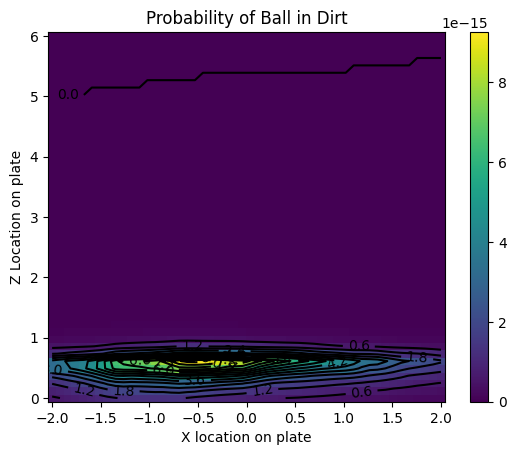

In [69]:
context = {
    "b_score": 0,
    "p_score": 0,
    "b_count": 0,
    "s_count": 0,
    "outs": 0,
    "pitch_num": 1,
    "on_1b": 0,
    "on_2b": 0,
    "on_3b": 0,
    "inning": 1,
    "p_isrighty": 1,
    "b_isrighty": 0,
    "is_top_inning": 1
}
indexes = [key for key, val in context.items()]
values = [val for key, val in context.items()]
context = pd.Series(values, index=indexes, dtype=float)


inputs = {
    "start_speed": 90,
    "spin_rate": 2400,
    "spin_dir": 159,
    "px": 0.5,
    "pz": 0.2,
    "pitch_type": "FF"
}

PITCH_TYPES = ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 'KN', 'SI', 'SL']

pitches = [inputs["pitch_type"]==val for val in PITCH_TYPES]
pitches = pd.Series(pitches, index=PITCH_TYPES, dtype=float)

model_path = "scripts/event/models/HL1_512.pt"
model = torch.load(model_path)
model = model.to(torch.device("cuda"))

model.eval()
torch.no_grad()
inputs = pd.Series([inputs["start_speed"], inputs["spin_rate"], inputs["spin_dir"], inputs["px"], inputs["pz"]], index=["start_speed", "spin_rate", "spin_dir", "px", "pz"], dtype=float)

pitch = pd.concat([inputs, pitches, context])

scaler = load(open('scripts/scaler.pkl', 'rb'))

# pitch = scaler.transform(np.array(pitch.values).reshape(1, -1))
#print(pitch_to)
# probabilities = model(torch.tensor(pitch, dtype=torch.float32).cuda())
# probabilities = pd.Series(probabilities.detach().cpu().numpy()[0], index=event_names.transpose().to_numpy()[0])

# print(probabilities["Ball"])
item = "Ball in Dirt"
n = 50
px, pz = np.meshgrid(np.linspace(-2, 2, n), np.linspace(0, 6, n))
scores = np.zeros((n, n))
for i in range(len(px)):
    for j in range(len(pz)):
        pitch["px"], pitch["pz"] = px[i,j], pz[i,j]
        to_model = scaler.transform(np.array(pitch.values).reshape(1, -1))
        probabilities = model(torch.tensor(to_model, dtype=torch.float32).cuda())
        probabilities = pd.Series(probabilities.detach().cpu().numpy()[0], index=event_names.transpose().to_numpy()[0])
        scores[i, j] = probabilities[item]



plt.figure()
plt.pcolor(px, pz, scores)
plt.colorbar()
plt.title("Probability of " + item)
plt.xlabel("X location on plate")
plt.ylabel("Z Location on plate")
cs = plt.contour(px, pz, scores, 15, colors="black")
plt.clabel(cs)